# 05 - A Eficácia Surpreendente da Regressão Linear


## Tudo o Que Você Precisa é de Regressão

Ao lidar com inferência causal, vimos como existem dois resultados potenciais para cada indivíduo: $Y_0$ é o resultado que o indivíduo teria se não recebesse o tratamento e $Y_1$ é o resultado se ele recebesse o tratamento. O ato de definir o tratamento $T$ como 0 ou 1 materializa um dos resultados potenciais e torna impossível para nós conhecermos o outro. Isso leva ao fato de que o efeito do tratamento individual $\tau_i = Y_{1i} - Y_{0i}$ é desconhecido. 

$
Y_i = Y_{0i} + T_i(Y_{1i} - Y_{0i}) = Y_{0i}(1-T_i) + T_i Y_{1i}
$

Então, por enquanto, vamos nos concentrar na tarefa mais simples de estimar o efeito causal médio. Com isso em mente, estamos aceitando o fato de que algumas pessoas respondem melhor do que outras ao tratamento, mas também estamos aceitando que não podemos saber quem são elas. Em vez disso, vamos apenas tentar ver se o tratamento funciona, **na média**.

$
ATE = E[Y_1 - Y_0]
$

Isso nos dará um modelo simplificado, com um efeito de tratamento constante $Y_{1i} = Y_{0i} + \kappa$. Se $\kappa$ for positivo, diremos que o tratamento tem, em média, um efeito positivo. Mesmo que algumas pessoas reajam mal a ele, em média, o impacto será positivo.

Vamos também lembrar que não podemos simplesmente estimar $E[Y_1 - Y_0]$ com a diferença nas médias $E[Y|T=1] - E[Y|T=0]$ devido ao viés. O viés surge frequentemente quando os tratados e não tratados são diferentes por razões outras que não o próprio tratamento. Uma maneira de ver isso é em como eles diferem no resultado potencial $Y_0$

$
E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{ATET} + \underbrace{\{ E[Y_0|T=1] - E[Y_0|T=0]\}}_{BIAS}
$

Anteriormente, vimos como podemos eliminar o viés com Experimentos Aleatórios, ou **Ensaio Controlado Randomizado** (ECR), como às vezes são chamados. O ECR força os tratados e os não tratados a serem iguais, e é por isso que o viés desaparece. Também vimos como colocar níveis de incerteza em torno de nossas estimativas para o efeito do tratamento. Nomeadamente, olhamos para o caso de aulas online versus presenciais, onde $T=0$ representa aulas presenciais e $T=1$ representa aulas online. Os estudantes foram aleatoriamente designados para um desses 2 tipos de aulas e, em seguida, seu desempenho em um exame foi avaliado. Construímos uma função de teste A/B que poderia comparar ambos os grupos, fornecer o efeito médio do tratamento e até colocar um intervalo de confiança em torno dele.

Now, it's time to see that we can do all of that with the workhorse of causal inference: **Linear Regression**! Think of it this way. If comparing treated and untreated means was an apple for dessert, linear regression would be cold and creamy tiramisu. Or if comparing treated and untreated is a sad and old loaf of white wonder bread, linear regression would be a crusty, soft crumb country loaf sourdough baked by Chad Robertson himself.

Agora, é hora de ver que podemos fazer tudo isso com a ferramenta central da inferência causal: **Regressão Linear**! Pense desta forma. Se comparar médias de tratados e não tratados fosse uma maçã de sobremesa, a regressão linear seria um tiramisu gelado e cremoso. Ou se comparar tratados e não tratados fosse um triste e velho pão de forma branco, a regressão linear seria um pão de fermento natural crocante e macio, assado pelo próprio Chad Robertson.

![img](./data/img/linear-regression/you_vs.png)

Vamos ver como essa beleza funciona. No código abaixo, queremos executar exatamente a mesma análise de comparação entre aulas online e presenciais. Mas, em vez de fazer toda aquela matemática de intervalos de confiança, nós simplesmente executamos uma regressão. Mais especificamente, estimamos o seguinte modelo:

$
exam_i = \beta_0 + \kappa \ Online_i + u_i
$

Isso significa que estamos modelando o resultado do exame como uma linha de base $\beta_0$ mais $\kappa$ se a aula for online. Claro, o resultado do exame é influenciado por variáveis adicionais (como o humor do aluno no dia do exame, horas estudadas e assim por diante). Mas não estamos realmente interessados em entender essas relações. Então, em vez disso, usamos o termo $u_i$ para representar tudo mais que não nos importa. Isso é chamado de erro do modelo.

Note que $Online$ é a indicação do nosso tratamento e, portanto, uma variável *dummy*. Ela é zero quando o tratamento é presencial e 1 se for online. Com isso em mente, podemos ver que a regressão linear irá recuperar $E[Y|T=0] = \beta_0$ e $E[Y|T=1] = \beta_0 + \kappa$. $\kappa$ será o nosso ATE (Efeito de Tratamento Médio).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

In [1]:
data = pd.read_csv("data/online_classroom.csv").query("format_blended==0")

result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


Isso é realmente incrível. Não estamos apenas aptos a estimar o ATE, mas também obtemos, gratuitamente, intervalos de confiança e valores-P! Além disso, podemos ver que a regressão está fazendo exatamente o que deveria fazer: comparar $E[Y|T=0]$ e $E[Y|T=1]$. A interseção é exatamente a média da amostra quando $T=0$, $E[Y|T=0]$, e o coeficiente do formato online é exatamente a diferença na média das amostras $E[Y|T=1] - E[Y|T=0]$. Não confia em mim? Sem problema. Você pode ver por si mesmo:

In [2]:
(data
 .groupby("format_ol")
 ["falsexam"]
 .mean())

format_ol
0    78.547485
1    73.635263
Name: falsexam, dtype: float64

Como esperado. Se você adicionar ao intercepto o ATE, ou seja, a estimativa do parâmetro do formato online, você obterá a média da amostra para os tratados: $78.5475 + (-4.9122) = 73.635263$.

## Teoria da Regressão

Não pretendo me aprofundar muito em como a regressão linear é construída e estimada. No entanto, um pouco de teoria ajudará bastante a explicar seu poder na inferência causal. Primeiramente, a regressão resolve um problema teórico de melhor predição linear. Seja $\beta^*$ um vetor de parâmetros:

$
\beta^* =\underset{\beta}{argmin} \ E[(Y_i - X_i'\beta)^2]
$

A regressão linear encontra os parâmetros que minimizam o erro quadrático médio (MSE, do inglês Mean Squared Error).

Se você diferenciar isso e igualar a zero, encontrará que a solução linear para este problema é dada por

$
\beta^* = E[X_i'X_i]^{-1}E[X_i' Y_i]
$

Podemos estimar este beta usando o equivalente da amostra:

$
\hat{\beta} = (X'X)^{-1}X' Y
$

Mas não acredite apenas na minha palavra. Se você é uma daquelas pessoas que entende melhor códigos do que fórmulas, tente por si mesmo:

In [3]:
X = data[["format_ol"]].assign(intercep=1)
y = data["falsexam"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([-4.9122215 , 78.54748458])

As fórmulas acima são bastante gerais. No entanto, vale a pena estudar o caso em que temos apenas um regressor. Na inferência causal, muitas vezes queremos estimar o impacto causal de uma variável $T$ em um resultado $y$. Então, usamos a regressão com essa única variável para estimar esse efeito. Mesmo que incluamos outras variáveis no modelo, elas geralmente são apenas auxiliares. Adicionar outras variáveis pode nos ajudar a estimar o efeito causal do tratamento, mas não estamos muito interessados em estimar seus parâmetros.

Com uma única variável regressora $T$, o parâmetro associado a ela será dado por

$
\beta_1 = \dfrac{Cov(Y_i, T_i)}{Var(T_i)} 
$

Se $T$ for atribuída aleatoriamente, $\beta_1$ é o ATE (Efeito de Tratamento Médio).

In [4]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

-4.91222149822695

Se tivermos mais de um regressor, podemos estender a fórmula a seguir para acomodar isso. Digamos que essas outras variáveis são apenas auxiliares e que estamos verdadeiramente interessados apenas em estimar o parâmetro $\kappa$ associado a $T$.

$
y_i = \beta_0 + \kappa T_i + \beta_1 X_{1i} + ... +\beta_k X_{ki} + u_i
$

$\kappa$ pode ser obtido com a seguinte fórmula

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

onde $\tilde{T_i}$ é o resíduo de uma regressão de $T_i$ em todas as outras covariáveis $X_{1i}, ..., X_{ki}$. Agora, vamos apreciar o quão legal é isso. Significa que o coeficiente de uma regressão multivariada é o coeficiente bivariado do mesmo regressor **após levar em conta o efeito de outras variáveis no modelo**. Em termos de inferência causal, $\kappa$ é o coeficiente bivariado de $T$ depois de ter usado todas as outras variáveis para prever isso.

Isso tem uma intuição interessante por trás. Se podemos prever $T$ usando outras variáveis, significa que não é aleatória. No entanto, podemos fazer com que $T$ seja tão boa quanto aleatória uma vez que controlamos para outras variáveis disponíveis. Para fazer isso, usamos a regressão linear para prever a partir das outras variáveis e depois pegamos os resíduos dessa regressão $\tilde{T}$. Por definição, $\tilde{T}$ não pode ser previsto pelas outras variáveis $X$ que já usamos para prever $T$. De forma bastante elegante, $\tilde{T}$ é uma versão do tratamento que não está associada a nenhuma outra variável em $X$.

A propósito, isso também é uma propriedade da regressão linear. Os resíduos são sempre ortogonais ou não correlacionados com qualquer uma das variáveis no modelo que os criou:

In [5]:
e = y - X.dot(beta)
print("Orthogonality imply that the dot product is zero:", np.dot(e, X))
X[["format_ol"]].assign(e=e).corr()

Orthogonality imply that the dot product is zero: [7.81597009e-13 4.63984406e-12]


,format_ol,e
format_ol,1.000000e+00,-9.419033e-16
e,-9.419033e-16,1.000000e+00


E o que é ainda mais interessante é que essas propriedades não dependem de nada! São verdades matemáticas, independentemente de como seus dados se parecem.

## Regressão para Dados Não Aleatórios

Até agora, trabalhamos com dados de experimentos aleatórios, mas, como sabemos, esses dados são difíceis de obter. Experimentos são muito caros para conduzir ou simplesmente inviáveis. É muito difícil convencer a McKinsey & Co. a fornecer seus serviços gratuitamente de forma aleatória para que possamos, de uma vez por todas, distinguir o valor que seus serviços de consultoria trazem do fato de que as empresas que podem pagar por eles já são muito bem-sucedidas.

Por essa razão, agora vamos nos aprofundar em dados não aleatórios ou observacionais. No exemplo a seguir, tentaremos estimar o impacto de um ano adicional de educação no salário por hora. Como você deve ter adivinhado, é extremamente difícil conduzir um experimento com educação. Você não pode simplesmente randomizar pessoas para terem 4, 8 ou 12 anos de educação. Neste caso, os dados observacionais são tudo que temos.

Primeiro, vamos estimar um modelo bem simples. Vamos fazer a regressão dos salários por hora em logaritmo em função dos anos de educação. Usamos logaritmos aqui para que nossas estimativas de parâmetros tenham uma interpretação em porcentagem (se você nunca ouviu falar sobre essas propriedades incríveis do logaritmo e quer saber por que isso acontece, confira [este link](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th)). Com isso, seremos capazes de dizer que 1 ano a mais de educação resulta em um aumento de x% no salário.

$
log(hwage)_i = \beta_0 + \beta_1 educ_i + u_i
$

In [6]:
wage = pd.read_csv("./data/wage.csv").dropna()
model_1 = smf.ols('np.log(hwage) ~ educ', data=wage.assign(hwage=wage["wage"]/wage["hours"])).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


A estimativa de $\beta_1$ é 0.0536, com um intervalo de confiança de 95% de (0.039, 0.068). Isso significa que este modelo prevê que os salários aumentarão cerca de 5,3% para cada ano adicional de educação. Esse aumento percentual está alinhado com a crença de que a educação impacta os salários de forma exponencial: esperamos que ir de 11 para 12 anos de educação (média para concluir o ensino médio) seja menos recompensador do que ir de 14 para 16 anos (média para concluir a faculdade).

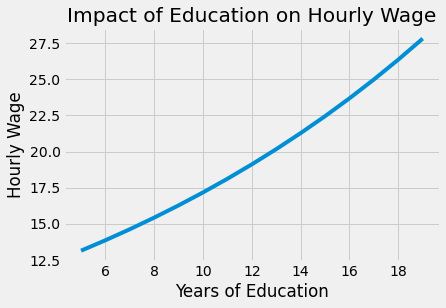

In [7]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

x = np.array(range(5, 20))
plt.plot(x, np.exp(model_1.params["Intercept"] + model_1.params["educ"] * x))
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage")
plt.title("Impact of Education on Hourly Wage")
plt.show()

Claro, não é porque podemos estimar este modelo simples que ele esteja correto. Observe como fui cuidadoso com minhas palavras ao dizer que ele **prevê** o salário a partir da educação. Nunca disse que essa previsão era causal. Na verdade, até agora, você provavelmente tem razões muito sérias para acreditar que este modelo está enviesado. Como nossos dados não vieram de um experimento aleatório, não sabemos se aqueles que receberam mais educação são comparáveis aos que receberam menos. Indo ainda mais longe, com base em nosso entendimento de como o mundo funciona, estamos muito certos de que eles não são comparáveis. Nomeadamente, podemos argumentar que aqueles com mais anos de educação provavelmente têm pais mais ricos, e que o aumento que estamos vendo nos salários à medida que aumentamos a educação é apenas um reflexo de como a riqueza familiar está associada a mais anos de educação. Colocando em termos matemáticos, pensamos que $E[Y_0|T=0] < E[Y_0|T=1]$, ou seja, aqueles com mais educação teriam uma renda maior de qualquer maneira, mesmo sem tantos anos de educação. Se você for realmente pessimista sobre educação, pode argumentar que ela pode até mesmo *reduzir* os salários ao manter as pessoas fora do mercado de trabalho e diminuir sua experiência.

Felizmente, em nossos dados, temos acesso a muitas outras variáveis. Podemos ver a educação dos pais `meduc`, `feduc`, a pontuação de `QI` da pessoa, o número de anos de experiência `exper` e o tempo de permanência da pessoa em sua atual empresa `tenure`. Até temos algumas variáveis fictícias para casamento e etnia negra.

In [8]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


Podemos incluir todas essas variáveis extras em um modelo e estimá-lo:

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}X_i + u_i
$

Para entender como isso ajuda com o problema de viés, vamos recapitular a decomposição bivariada da regressão linear multivariada.

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

Esta fórmula diz que podemos prever `educ` a partir da educação dos pais, do QI, da experiência e assim por diante. Depois de fazer isso, ficaremos com uma versão de `educ`, $\tilde{educ}$, que não está correlacionada com todas as variáveis incluídas anteriormente. Isso quebrará argumentos como "pessoas que têm mais anos de educação têm isso porque têm QI mais alto. Não é o caso de a educação levar a salários mais altos. É apenas o caso de estar correlacionada com o QI, que é o que impulsiona os salários". Bem, se incluirmos o QI no nosso modelo, então $\kappa$ se torna o retorno de um ano adicional de educação mantendo o QI fixo. Faça uma pausa para entender o que isso implica. Mesmo que não possamos usar ensaios controlados randomizados para manter outros fatores iguais entre tratados e não tratados, a regressão pode fazer isso incluindo esses mesmos fatores no modelo, mesmo que os dados não sejam aleatórios!

In [9]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage["educ"]
y = wage["lhwage"]

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

0.041147191010057635

Este coeficiente que acabamos de estimar nos diz que, para pessoas com o mesmo QI, experiência, tempo de permanência, idade e assim por diante, devemos esperar que um ano adicional de educação esteja associado a um aumento de 4,11% no salário por hora. Isso confirma nossa suspeita de que o primeiro modelo simples com apenas `educ` estava enviesado. Também confirma que esse viés estava superestimando o impacto da educação. Uma vez que controlamos para outros fatores, o impacto estimado da educação caiu.

Se formos mais sábios e usarmos software que outras pessoas escreveram em vez de codificar tudo por conta própria, podemos até colocar um intervalo de confiança em torno dessa estimativa.

In [10]:
model_2 = smf.ols('lhwage ~ educ +' + '+'.join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


## Viés de Variável Omitida ou Confundimento

A questão que permanece é: este parâmetro que estimamos é causal? Infelizmente, não podemos dizer com certeza. Podemos argumentar que o primeiro modelo simples que regrediu o salário sobre a educação provavelmente não é causal. Ele omite variáveis importantes que estão correlacionadas tanto com a educação quanto com os salários. Sem controlar por elas, o impacto estimado da educação também está capturando o impacto dessas outras variáveis que não foram incluídas no modelo.

Para entender melhor como esse viés funciona, vamos supor que o modelo verdadeiro de como a educação afeta o salário seja algo assim

$
Wage_i = \alpha + \kappa \ Educ_i + A_i'\beta + u_i
$

o salário é afetado pela educação, que é medida pelo tamanho de $\kappa$, e por fatores adicionais de habilidade, denotados como o vetor $A$. Se omitirmos a habilidade do nosso modelo, nossa estimativa para $\kappa$ será assim:

$
\dfrac{Cov(Wage_i, Educ_i)}{Var(Educ_i)} = \kappa + \beta'\delta_{Ability}
$

onde $\delta_{A}$ é o vetor de coeficientes da regressão de $Educ$ em $A$.

O ponto chave aqui é que isso não será exatamente o $\kappa$ que queremos. Em vez disso, vem com este termo extra irritante $\beta'\delta_{A}$. Este termo é o impacto do $A$ omitido no $Wage$, $\beta$ vezes o impacto do omitido no incluído $Educ$. Isso é importante para os economistas a ponto de Joshua Angrist ter feito um mantra disso, para que os alunos possam recitá-lo em meditação:

```
"Curta é igual a longa 
mais o efeito da omitida 
vezes a regressão da omitida na incluída"
```

Aqui, a regressão curta é aquela que omite variáveis, enquanto a longa é aquela que as inclui. Essa fórmula ou mantra nos dá mais insights sobre a natureza do viés. Primeiro, o termo de viés será zero se as variáveis omitidas não tiverem impacto na variável dependente $Y$. Isso faz total sentido. Não preciso controlar por coisas que são irrelevantes para os salários ao tentar entender o impacto da educação neles (como a altura dos lírios do campo). Em segundo lugar, o termo de viés também será zero se as variáveis omitidas não tiverem impacto na variável de tratamento. Isso também faz sentido intuitivamente. Se tudo o que impacta a educação foi incluído no modelo, não há como o impacto estimado da educação estar misturado com uma correlação da educação em algo mais que também impacta os salários.

![img](data/img/linear-regression/confused_cat.png)

Para colocar de forma mais sucinta, dizemos que **não há Viés de Variável Omitida (OVB) se todas as variáveis de confundimento forem contabilizadas no modelo**. Também podemos aproveitar nosso conhecimento sobre gráficos causais aqui. Uma variável de confundimento é aquela que **causa tanto o tratamento quanto o resultado**. No exemplo do salário, o QI é um confundidor. Pessoas com QI alto tendem a completar mais anos de educação porque é mais fácil para elas, então podemos dizer que o QI causa a educação. Pessoas com QI alto também tendem a ser naturalmente mais produtivas e, consequentemente, têm salários mais altos, então o QI também causa o salário. Como os confundidores são variáveis que afetam tanto o tratamento quanto o resultado, marcamos eles com uma seta indo para T e Y. Aqui, eu os denotei com $W$. Também marquei a causalidade positiva com vermelho e a causalidade negativa com azul.

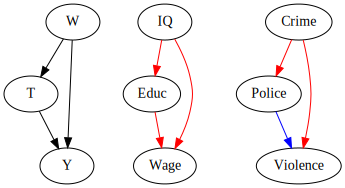

In [11]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Educ", color="red"), g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g.edge("Crime", "Police", color="red"), g.edge("Crime", "Violence", color="red"), 
g.edge("Police", "Violence", color="blue")

g

Gráficos causais são excelentes para representar nossa compreensão do mundo e entender como o viés de confundimento funciona. Em nosso primeiro exemplo, temos um gráfico onde a educação causa o salário: mais educação leva a salários mais altos. No entanto, o QI também causa o salário e também causa a educação: um QI alto causa tanto mais educação quanto um salário mais alto. Se não considerarmos o QI em nosso modelo, parte de seu efeito sobre o salário fluirá através da correlação com a educação. Isso fará com que o impacto da educação pareça maior do que realmente é. Este é um exemplo de viés positivo.

Apenas para dar outro exemplo, mas com viés negativo, considere o gráfico causal sobre o efeito da polícia na violência na cidade. O que normalmente vemos no mundo é que cidades com força policial maior também têm mais violência. Isso significa que a polícia está causando a violência? Bem, pode ser, não acho que seja relevante entrar nessa discussão aqui. Mas há também uma forte possibilidade de que haja uma variável de confundimento nos fazendo ver uma versão tendenciosa do impacto da polícia na violência. Pode ser que aumentar a força policial diminua a violência. No entanto, uma terceira variável, o crime, causa tanto mais violência quanto mais força policial. Se não a considerarmos, o impacto do crime na violência fluirá através da força policial, fazendo parecer que ela aumenta a violência. Este é um exemplo de viés negativo.

Os gráficos causais também podem nos mostrar como tanto a regressão quanto os ensaios controlados randomizados são corretos para o viés de confundimento. Os ensaios controlados randomizados fazem isso ao romper a conexão do confundidor com a variável de tratamento. Ao tornar $T$ aleatório, por definição, nada pode causá-lo.

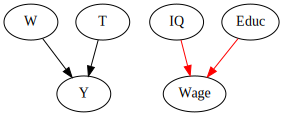

In [12]:
g = gr.Digraph()

g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g

Por outro lado, a regressão faz isso comparando o efeito de $T$ enquanto mantém o confundidor $W$ fixado em um nível constante. Com a regressão, não é o caso de que W deixe de causar T e Y. É apenas que ele é mantido constante, para que não possa influenciar as mudanças em T e Y.

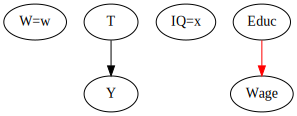

In [13]:
g = gr.Digraph()

g.node("W=w"), g.edge("T", "Y")
g.node("IQ=x"), g.edge("Educ", "Wage", color="red")

g

Agora, voltando à nossa pergunta, o parâmetro que estimamos para o impacto de "educ" no salário é causal? Sinto muito, mas isso dependerá de nossa capacidade de argumentar a favor ou contra o fato de que todos os confundidores foram incluídos no modelo. Pessoalmente, acredito que não foram. Por exemplo, não incluímos a riqueza familiar. Mesmo que tenhamos incluído a educação da família, isso só pode ser visto como um proxy para a riqueza. Também não consideramos fatores como ambição pessoal. Pode ser que a ambição seja o que causa tanto mais anos de educação quanto um salário mais alto, então ela é um confundidor. Isso é para mostrar que **a inferência causal com dados não aleatórios ou observacionais deve sempre ser feita com precaução**. Nunca podemos ter certeza de que todos os confundidores foram considerados.


## Conceitos-chave

Nós cobrimos muito terreno com a regressão. Vimos como a regressão pode ser usada para realizar testes A/B e como convenientemente nos fornece intervalos de confiança. Em seguida, estudamos como a regressão resolve um problema de previsão e é a melhor aproximação linear para a função de expectativa condicional (FEC). Também discutimos como, no caso bivariado, o coeficiente de tratamento da regressão é a covariância entre o tratamento e o resultado dividido pela variância do tratamento. Expandindo para o caso multivariado, descobrimos como a regressão nos dá uma interpretação de isolamento parcial do coeficiente de tratamento: ele pode ser interpretado como a forma como o resultado mudaria com o tratamento, mantendo todas as outras variáveis incluídas constantes. Isso é o que os economistas adoram se referir como *ceteris paribus*.

Por fim, fizemos uma virada para entender o viés. Vimos como `Curta igual a longa mais o efeito da omitida vezes a regressão da omitida na incluída`. Isso lançou alguma luz sobre como o viés surge. Descobrimos que a fonte do viés de variável omitida é o confundimento: uma variável que afeta tanto o tratamento quanto o resultado. Por fim, usamos gráficos causais para ver como RCT e regressão corrigem o confundimento.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<em> <b>Nota de Tradução: </b>[Variáveis dummy](https://pt.wikipedia.org/wiki/Vari%C3%A1vel_dummy_(estat%C3%ADstica)), também chamadas de fictícias, são variáveis criadas para representar uma variável com duas ou mais categorias. Esse conceito será mais explorado no próximo capitulo. </em>

<div align="center">
<a href="04-Graphical-Causal-Models.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="06-Grouped-and-Dummy-Regression.ipynb">Próximo --></a>  
</div>